# Topic modelling

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [5]:
df = pd.read_csv("full_df.csv", compression="gzip")

In [13]:
df.head()

,filename,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr,word_level_average_confidence_ocr,word_level_average_confidence_reocr
0,DDD_010197037_001.jp2,"['No.', '9922.', 'Tweede', 'Blad.', 'Vrijdag',...","['JSo.', '9822', 'xTweede', 'Blad.', 'Vrijdag'...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","['ISO.', '9922', '-Tweede', 'Blad.', 'ss*', 'V...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9...",0.719354,0.718463
1,DDD_011219339_001.jp2,"['De', 'Surinamer', 'Redactie', 'J.', 'WILLEBR...","['De', 'Surinamer', '•v*', 'WILLEBRANDS:i^', '...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","['Whd^Mmumr', 'Redactie', 'J.', 'WILLEBRANDS',...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9...",0.765606,0.889051
2,DDD_011179281_001.jp2,"['DE', 'GRONDWET.', 'Mrs.', 'L.', 'Mulder,', '...","['DE', 'GRONDWET.', 'Mrs.', '3L..', 'Mulder,',...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","['DE', 'GRONDWET.', 'Mrs.', 'Xj.', 'Melder,', ...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74...",0.836059,0.805909
3,DDD_010948945_001.jp2,"['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","[0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.86, 0.63,...","['Ê', '•', ':>', '%', 'V', 'f', 'A', 'i', '*',...","[0.27, 0.44, 0.14, 1.0, 0.13, 0.33, 1.0, 0.3, ...",0.881544,0.918112
4,MMGARO01_000177181_002_master.jp2,"['De', 'troepen', 'vertrokken', '8', 'en', '9'...","['De', 'tioepen', 'vertrokken', '8', 'en', '9'...","[0.59, 0.32, 0.32, 0.78, 0.07, 1.0, 0.25, 0.18...","['De', 'troepen', 'vertrokken', '8', 'en', '9'...","[0.5, 0.98, 0.99, 0.41, 0.46, 0.76, 0.61, 0.96...",0.318412,0.877502


In [9]:
#from tabulate import tabulate

In [12]:
#print(tabulate(df.head(2), tablefmt="pipe", headers="keys"))

### Basic exploration

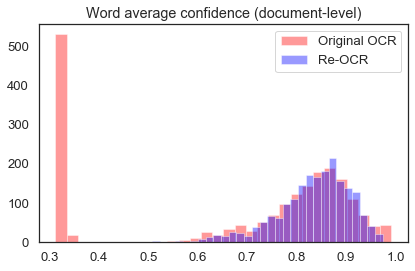

In [7]:
sns.distplot(df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()